In [35]:
# === CELL 1: GPU Check and Setup ===

# Check GPU availability
import tensorflow as tf
import os

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Check GPU details (will only work in Colab)
print("\nGPU Details:")
# This command is for Colab environment
# !nvidia-smi

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU Details:


In [36]:
# === CELL 2: Install Required Libraries and Imports ===

# Install additional libraries (will only work in Colab)
# !pip install -q kaggle opencv-python-headless scikit-learn matplotlib seaborn pillow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import zipfile
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Sklearn for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [37]:
!export KAGGLE_API_TOKEN=KGAT_0de04b77b71aa91707632f5cb5e93643


In [38]:

# 1) تثبيت Kaggle
!pip install -q kaggle

# 2) إنشاء ملف kaggle.json بالطريقة التقليدية
import json
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump({"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_API_KEY"}, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# 3) تنزيل وفك الضغط
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip -p brain_tumor_data


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 90% 134M/149M [00:00<00:00, 1.34GB/s]
100% 149M/149M [00:00<00:00, 1.19GB/s]


In [39]:
# === CELL 6: Set Paths and Count Images ===

# Set correct paths (adjust based on actual structure)
# The dataset typically has Training and Testing folders
train_dir = 'brain_tumor_data/Training'
test_dir = 'brain_tumor_data/Testing'

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Count images per class
print("\n=== Training Set ===")
train_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        train_counts[class_name] = count
        print(f"{class_name}: {count} images")

print(f"\nTotal training images: {sum(train_counts.values())}")

print("\n=== Testing Set ===")
test_counts = {}
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        test_counts[class_name] = count
        print(f"{class_name}: {count} images")

print(f"\nTotal testing images: {sum(test_counts.values())}")



=== Training Set ===
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

Total training images: 5712

=== Testing Set ===
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images

Total testing images: 1311


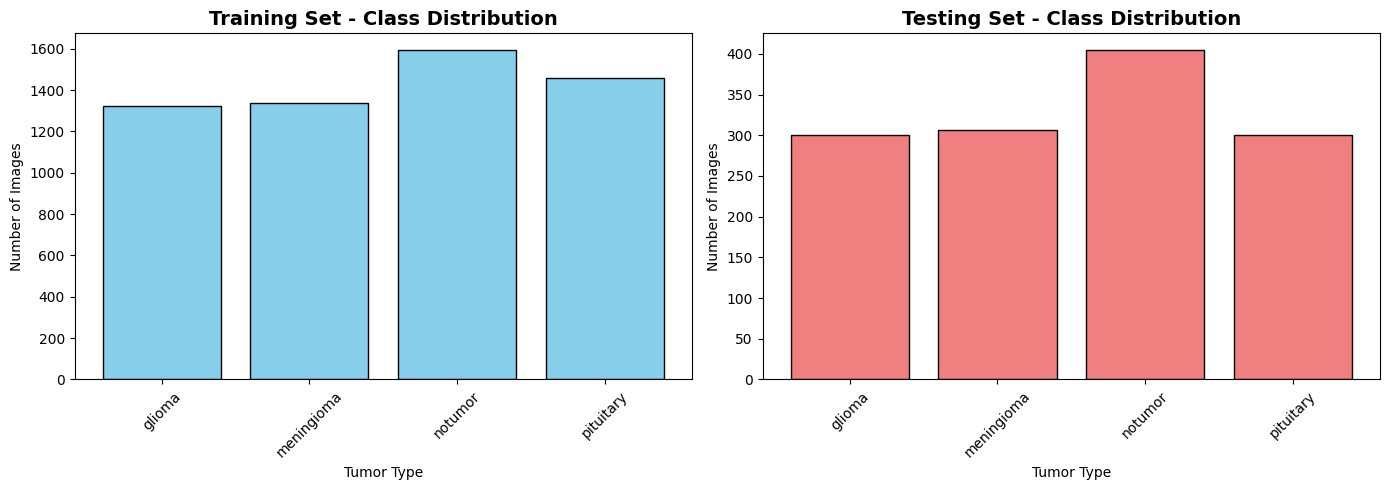

✓ Class distribution visualized!


In [40]:
# === CELL 7: Visualize Class Distribution ===

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue', edgecolor='black')
axes[0].set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tumor Type')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

# Testing set distribution
axes[1].bar(test_counts.keys(), test_counts.values(), color='lightcoral', edgecolor='black')
axes[1].set_title('Testing Set - Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tumor Type')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Class distribution visualized!")

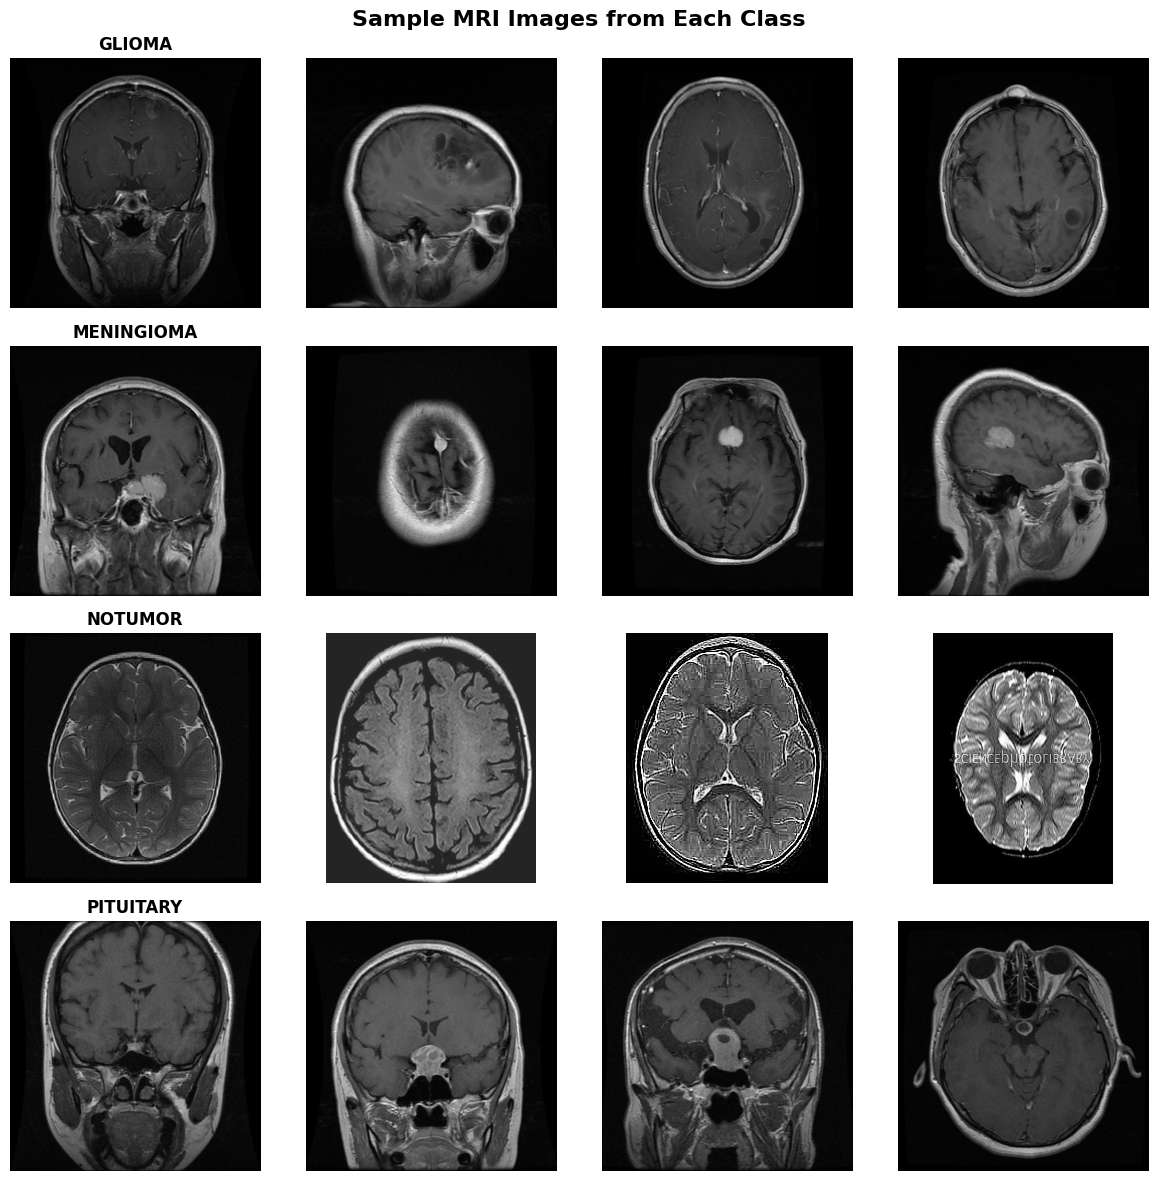

✓ Sample images visualized!


In [41]:

# === CELL 8: Visualize Sample Images ===

# Visualize sample images from each class
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Sample MRI Images from Each Class', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)[:4]  # Get first 4 images

    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[idx, i].imshow(img)
        axes[idx, i].axis('off')
        if i == 0:
            axes[idx, i].set_title(class_name.upper(), fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Sample images visualized!")

In [42]:
# === CELL 9: Data Preprocessing and Augmentation Setup ===

# Image parameters
IMG_SIZE = 224  # Standard input size for VGG16 and ResNet50
BATCH_SIZE = 32
NUM_CLASSES = 4

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Only rescaling for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices
class_indices = train_generator.class_indices
print("\nClass indices:", class_indices)
print("✓ Data generators created successfully!")



Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
✓ Data generators created successfully!


In [44]:
# === CELL 10: Build VGG16 Model ===

# Load the VGG16 base model (pre-trained on ImageNet)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the convolutional base
vgg16_base.trainable = False

# Create a new model on top
vgg16_model = models.Sequential([
    vgg16_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

vgg16_model.summary()
print("\n✓ VGG16 Model built and compiled successfully!")

# === CELL 11: VGG16 Training (Phase 1: Frozen Base) ===

# Callbacks for VGG16
vgg16_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'vgg16_best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train VGG16 model
print("\n" + "="*50)
print("Training VGG16 Model (Phase 1: Frozen Base)")
print("="*50 + "\n")

EPOCHS_PHASE1 = 10

vgg16_history_phase1 = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS_PHASE1,
    callbacks=vgg16_callbacks,
    verbose=1
)

print("\n✓ VGG16 Phase 1 training completed!")




print("\n✓ VGG16 fine-tuning completed!")

# Save final model
vgg16_model.save('vgg16_final_model.h5')
print("\n✓ VGG16 model saved!")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


✓ VGG16 Model built and compiled successfully!

Training VGG16 Model (Phase 1: Frozen Base)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.2872 - loss: 1.5384 - precision_5: 0.3150 - recall_5: 0.0721
Epoch 1: val_accuracy improved from -inf to 0.53199, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 580ms/step - accuracy: 0.2874 - loss: 1.5377 - precision_5: 0.3155 - recall_5: 0.0721 - val_accuracy: 0.5320 - val_loss: 1.2567 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.4369 - loss: 1.2383 - precision_5: 0.6913 - recall_5: 0.0795
Epoch 2: val_accuracy improved from 0.53199 to 0.62664, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 570ms/step - accuracy: 0.4372 - loss: 1.2380 - precision_5: 0.6919 - recall_5: 0.0798 - val_accuracy: 0.6266 - val_loss: 1.1449 - val_precision_5: 0.9048 - val_recall_5: 0.0500 - learning_rate: 1.0000e-04
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.5993 - loss: 1.0623 - precision_5: 0.8883 - recall_5: 0.1750
Epoch 3: val_accuracy improved from 0.62664 to 0.65469, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 560ms/step - accuracy: 0.5994 - loss: 1.0621 - precision_5: 0.8882 - recall_5: 0.1752 - val_accuracy: 0.6547 - val_loss: 1.0615 - val_precision_5: 0.8010 - val_recall_5: 0.1341 - learning_rate: 1.0000e-04
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6590 - loss: 0.9438 - precision_5: 0.8866 - recall_5: 0.2903
Epoch 4: val_accuracy improved from 0.65469 to 0.65557, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 554ms/step - accuracy: 0.6591 - loss: 0.9436 - precision_5: 0.8867 - recall_5: 0.2905 - val_accuracy: 0.6556 - val_loss: 1.0126 - val_precision_5: 0.8276 - val_recall_5: 0.2524 - learning_rate: 1.0000e-04
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.6960 - loss: 0.8671 - precision_5: 0.8850 - recall_5: 0.3723
Epoch 5: val_accuracy improved from 0.65557 to 0.67572, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 555ms/step - accuracy: 0.6961 - loss: 0.8670 - precision_5: 0.8851 - recall_5: 0.3724 - val_accuracy: 0.6757 - val_loss: 0.9508 - val_precision_5: 0.8244 - val_recall_5: 0.3786 - learning_rate: 1.0000e-04
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7341 - loss: 0.7855 - precision_5: 0.8794 - recall_5: 0.4547
Epoch 6: val_accuracy did not improve from 0.67572
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 556ms/step - accuracy: 0.7340 - loss: 0.7855 - precision_5: 0.8794 - recall_5: 0.4547 - val_accuracy: 0.6573 - val_loss: 0.9344 - val_precision_5: 0.8054 - val_recall_5: 0.3918 - learning_rate: 1.0000e-04
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7349 - loss: 0.7465 - precision_5: 0.8814 - recall_5: 0.5133
Epoch 7: val_accuracy improved from 0.67572 to 0.67923, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 562ms/step - accuracy: 0.7349 - loss: 0.7465 - precision_5: 0.8814 - recall_5: 0.5134 - val_accuracy: 0.6792 - val_loss: 0.8973 - val_precision_5: 0.7953 - val_recall_5: 0.4496 - learning_rate: 1.0000e-04
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7491 - loss: 0.7147 - precision_5: 0.8709 - recall_5: 0.5566
Epoch 8: val_accuracy did not improve from 0.67923
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 554ms/step - accuracy: 0.7491 - loss: 0.7146 - precision_5: 0.8709 - recall_5: 0.5567 - val_accuracy: 0.6766 - val_loss: 0.8734 - val_precision_5: 0.7798 - val_recall_5: 0.4873 - learning_rate: 1.0000e-04
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.7682 - loss: 0.6712 - precision_5: 0.8815 - recall_5: 0.5924
Epoch 9: val_accuracy did not improve from 0.67923
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.7682 - loss: 0.6711 - precision_5: 0.8814 - recall_5: 0.5924 - val_accuracy: 0.6766 - val_loss: 0.8506 - v


✓ VGG16 Phase 1 training completed!

✓ VGG16 fine-tuning completed!

✓ VGG16 model saved!


In [45]:
# === CELL 12: VGG16 Fine-tuning (Phase 2: Unfrozen Layers) ===

# Fine-tuning: Unfreeze some layers of base model
print("\n" + "="*50)
print("Fine-tuning VGG16 Model (Phase 2: Unfrozen Layers)")
print("="*50 + "\n")

# Unfreeze the last 4 convolutional blocks
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

# Recompile with lower learning rate
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print(f"Trainable parameters after unfreezing: {sum([tf.size(w).numpy() for w in vgg16_model.trainable_weights]):,}")

EPOCHS_PHASE2 = 15

vgg16_history_phase2 = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS_PHASE2,
    callbacks=vgg16_callbacks,
    verbose=1
)


Fine-tuning VGG16 Model (Phase 2: Unfrozen Layers)

Trainable parameters after unfreezing: 7,211,780
Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8053 - loss: 0.5483 - precision_6: 0.8584 - recall_6: 0.7192
Epoch 1: val_accuracy improved from 0.67923 to 0.70815, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 632ms/step - accuracy: 0.8054 - loss: 0.5479 - precision_6: 0.8585 - recall_6: 0.7196 - val_accuracy: 0.7082 - val_loss: 0.7254 - val_precision_6: 0.7461 - val_recall_6: 0.6748 - learning_rate: 1.0000e-05
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8587 - loss: 0.3983 - precision_6: 0.8822 - recall_6: 0.8294
Epoch 2: val_accuracy improved from 0.70815 to 0.79579, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 587ms/step - accuracy: 0.8588 - loss: 0.3981 - precision_6: 0.8823 - recall_6: 0.8295 - val_accuracy: 0.7958 - val_loss: 0.5692 - val_precision_6: 0.8177 - val_recall_6: 0.7783 - learning_rate: 1.0000e-05
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8948 - loss: 0.3025 - precision_6: 0.9090 - recall_6: 0.8791
Epoch 3: val_accuracy improved from 0.79579 to 0.81770, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 562ms/step - accuracy: 0.8948 - loss: 0.3026 - precision_6: 0.9090 - recall_6: 0.8791 - val_accuracy: 0.8177 - val_loss: 0.4945 - val_precision_6: 0.8389 - val_recall_6: 0.7984 - learning_rate: 1.0000e-05
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8974 - loss: 0.2938 - precision_6: 0.9099 - recall_6: 0.8827
Epoch 4: val_accuracy improved from 0.81770 to 0.82910, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 574ms/step - accuracy: 0.8974 - loss: 0.2938 - precision_6: 0.9099 - recall_6: 0.8827 - val_accuracy: 0.8291 - val_loss: 0.4816 - val_precision_6: 0.8448 - val_recall_6: 0.8160 - learning_rate: 1.0000e-05
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9001 - loss: 0.2822 - precision_6: 0.9092 - recall_6: 0.8908
Epoch 5: val_accuracy improved from 0.82910 to 0.85101, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 601ms/step - accuracy: 0.9001 - loss: 0.2821 - precision_6: 0.9093 - recall_6: 0.8909 - val_accuracy: 0.8510 - val_loss: 0.4221 - val_precision_6: 0.8626 - val_recall_6: 0.8361 - learning_rate: 1.0000e-05
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9262 - loss: 0.2341 - precision_6: 0.9400 - recall_6: 0.9130
Epoch 6: val_accuracy improved from 0.85101 to 0.85364, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 138s 575ms/step - accuracy: 0.9261 - loss: 0.2341 - precision_6: 0.9399 - recall_6: 0.9130 - val_accuracy: 0.8536 - val_loss: 0.4104 - val_precision_6: 0.8683 - val_recall_6: 0.8493 - learning_rate: 1.0000e-05
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9167 - loss: 0.2265 - precision_6: 0.9290 - recall_6: 0.9077
Epoch 7: val_accuracy improved from 0.85364 to 0.85714, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 576ms/step - accuracy: 0.9168 - loss: 0.2264 - precision_6: 0.9291 - recall_6: 0.9077 - val_accuracy: 0.8571 - val_loss: 0.4136 - val_precision_6: 0.8643 - val_recall_6: 0.8484 - learning_rate: 1.0000e-05
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9339 - loss: 0.1955 - precision_6: 0.9407 - recall_6: 0.9261
Epoch 8: val_accuracy did not improve from 0.85714
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 570ms/step - accuracy: 0.9339 - loss: 0.1956 - precision_6: 0.9406 - recall_6: 0.9261 - val_accuracy: 0.8414 - val_loss: 0.4478 - val_precision_6: 0.8537 - val_recall_6: 0.8387 - learning_rate: 1.0000e-05
Epoch 9/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9233 - loss: 0.2192 - precision_6: 0.9297 - recall_6: 0.9145
Epoch 9: val_accuracy did not improve from 0.85714
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 570ms/step - accuracy: 0.9234 - loss: 0.2191 - precision_6: 0.9297 - recall_6: 0.9146 - val_accuracy: 0.8554 - val_loss: 0.4315 - v

143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 572ms/step - accuracy: 0.9356 - loss: 0.1860 - precision_6: 0.9473 - recall_6: 0.9260 - val_accuracy: 0.8685 - val_loss: 0.3980 - val_precision_6: 0.8769 - val_recall_6: 0.8615 - learning_rate: 1.0000e-05
Epoch 11/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9388 - loss: 0.1756 - precision_6: 0.9444 - recall_6: 0.9334
Epoch 11: val_accuracy improved from 0.86854 to 0.87993, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 560ms/step - accuracy: 0.9388 - loss: 0.1756 - precision_6: 0.9444 - recall_6: 0.9334 - val_accuracy: 0.8799 - val_loss: 0.3756 - val_precision_6: 0.8837 - val_recall_6: 0.8720 - learning_rate: 1.0000e-05
Epoch 12/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9434 - loss: 0.1577 - precision_6: 0.9495 - recall_6: 0.9369
Epoch 12: val_accuracy did not improve from 0.87993
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.9434 - loss: 0.1577 - precision_6: 0.9495 - recall_6: 0.9370 - val_accuracy: 0.8659 - val_loss: 0.3867 - val_precision_6: 0.8799 - val_recall_6: 0.8606 - learning_rate: 1.0000e-05
Epoch 13/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9482 - loss: 0.1484 - precision_6: 0.9560 - recall_6: 0.9427
Epoch 13: val_accuracy improved from 0.87993 to 0.88869, saving model to vgg16_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.9482 - loss: 0.1484 - precision_6: 0.9560 - recall_6: 0.9427 - val_accuracy: 0.8887 - val_loss: 0.3362 - val_precision_6: 0.9010 - val_recall_6: 0.8852 - learning_rate: 1.0000e-05
Epoch 14/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9319 - loss: 0.1759 - precision_6: 0.9410 - recall_6: 0.9260
Epoch 14: val_accuracy did not improve from 0.88869
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 573ms/step - accuracy: 0.9320 - loss: 0.1758 - precision_6: 0.9411 - recall_6: 0.9261 - val_accuracy: 0.8747 - val_loss: 0.3812 - val_precision_6: 0.8811 - val_recall_6: 0.8703 - learning_rate: 1.0000e-05
Epoch 15/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9492 - loss: 0.1455 - precision_6: 0.9534 - recall_6: 0.9405
Epoch 15: val_accuracy did not improve from 0.88869
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 577ms/step - accuracy: 0.9492 - loss: 0.1455 - precision_6: 0.9534 - recall_6: 0.9405 - val_accuracy: 0.8703 - val_loss: 0.3863

In [46]:
# === CELL 13: ResNet50 Model Building ===

def build_resnet50_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Build ResNet50 model with transfer learning
    """
    # Load pre-trained ResNet50 (without top layers)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Build the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

# Build ResNet50 model
resnet50_model, resnet50_base = build_resnet50_model()

# Compile the model
resnet50_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("\n=== ResNet50 Model Architecture ===")
resnet50_model.summary()
print(f"\nTotal parameters: {resnet50_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in resnet50_model.trainable_weights]):,}")



=== ResNet50 Model Architecture ===


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,777,348 (94.52 MB)

 Trainable params: 1,185,540 (4.52 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


Total parameters: 24,777,348
Trainable parameters: 1,185,540


In [47]:
# === CELL 14: ResNet50 Training (Phase 1: Frozen Base) ===

# Callbacks for ResNet50
resnet50_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'resnet50_best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train ResNet50 model
print("\n" + "="*50)
print("Training ResNet50 Model (Phase 1: Frozen Base)")
print("="*50 + "\n")

EPOCHS_PHASE1 = 10

resnet50_history_phase1 = resnet50_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS_PHASE1,
    callbacks=resnet50_callbacks,
    verbose=1
)

print("\n✓ ResNet50 Phase 1 training completed!")




Training ResNet50 Model (Phase 1: Frozen Base)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.4561 - loss: 1.1506 - precision_7: 0.7321 - recall_7: 0.2017
Epoch 1: val_accuracy improved from -inf to 0.40666, saving model to resnet50_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 620ms/step - accuracy: 0.4564 - loss: 1.1502 - precision_7: 0.7322 - recall_7: 0.2020 - val_accuracy: 0.4067 - val_loss: 1.3120 - val_precision_7: 0.8776 - val_recall_7: 0.0377 - learning_rate: 1.0000e-04
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5818 - loss: 0.9845 - precision_7: 0.7546 - recall_7: 0.3369
Epoch 2: val_accuracy improved from 0.40666 to 0.50833, saving model to resnet50_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 581ms/step - accuracy: 0.5818 - loss: 0.9844 - precision_7: 0.7546 - recall_7: 0.3370 - val_accuracy: 0.5083 - val_loss: 1.1860 - val_precision_7: 0.8167 - val_recall_7: 0.0859 - learning_rate: 1.0000e-04
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5993 - loss: 0.9397 - precision_7: 0.7484 - recall_7: 0.3998
Epoch 3: val_accuracy improved from 0.50833 to 0.60999, saving model to resnet50_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 542ms/step - accuracy: 0.5993 - loss: 0.9396 - precision_7: 0.7485 - recall_7: 0.3999 - val_accuracy: 0.6100 - val_loss: 1.0899 - val_precision_7: 0.7843 - val_recall_7: 0.1753 - learning_rate: 1.0000e-04
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6138 - loss: 0.8996 - precision_7: 0.7439 - recall_7: 0.4295
Epoch 4: val_accuracy did not improve from 0.60999
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 532ms/step - accuracy: 0.6138 - loss: 0.8996 - precision_7: 0.7438 - recall_7: 0.4295 - val_accuracy: 0.5837 - val_loss: 1.0216 - val_precision_7: 0.7530 - val_recall_7: 0.3260 - learning_rate: 1.0000e-04
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6154 - loss: 0.8764 - precision_7: 0.7322 - recall_7: 0.4445
Epoch 5: val_accuracy improved from 0.60999 to 0.61788, saving model to resnet50_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 538ms/step - accuracy: 0.6155 - loss: 0.8763 - precision_7: 0.7323 - recall_7: 0.4447 - val_accuracy: 0.6179 - val_loss: 0.9935 - val_precision_7: 0.7151 - val_recall_7: 0.4312 - learning_rate: 1.0000e-04
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6403 - loss: 0.8469 - precision_7: 0.7452 - recall_7: 0.4859
Epoch 6: val_accuracy did not improve from 0.61788
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 521ms/step - accuracy: 0.6403 - loss: 0.8469 - precision_7: 0.7452 - recall_7: 0.4859 - val_accuracy: 0.6117 - val_loss: 1.0123 - val_precision_7: 0.7098 - val_recall_7: 0.4566 - learning_rate: 1.0000e-04
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.6583 - loss: 0.8389 - precision_7: 0.7499 - recall_7: 0.5076
Epoch 7: val_accuracy improved from 0.61788 to 0.61963, saving model to resnet50_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 527ms/step - accuracy: 0.6583 - loss: 0.8388 - precision_7: 0.7499 - recall_7: 0.5076 - val_accuracy: 0.6196 - val_loss: 0.9798 - val_precision_7: 0.7141 - val_recall_7: 0.4750 - learning_rate: 1.0000e-04
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6534 - loss: 0.8165 - precision_7: 0.7453 - recall_7: 0.5128
Epoch 8: val_accuracy improved from 0.61963 to 0.64417, saving model to resnet50_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 529ms/step - accuracy: 0.6535 - loss: 0.8164 - precision_7: 0.7454 - recall_7: 0.5129 - val_accuracy: 0.6442 - val_loss: 0.9487 - val_precision_7: 0.7290 - val_recall_7: 0.5259 - learning_rate: 1.0000e-04
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.6829 - loss: 0.7662 - precision_7: 0.7714 - recall_7: 0.5581
Epoch 9: val_accuracy did not improve from 0.64417
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 540ms/step - accuracy: 0.6828 - loss: 0.7664 - precision_7: 0.7713 - recall_7: 0.5580 - val_accuracy: 0.6380 - val_loss: 0.9539 - val_precision_7: 0.7200 - val_recall_7: 0.5250 - learning_rate: 1.0000e-04
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.6870 - loss: 0.7671 - precision_7: 0.7594 - recall_7: 0.5601
Epoch 10: val_accuracy did not improve from 0.64417
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 535ms/step - accuracy: 0.6869 - loss: 0.7672 - precision_7: 0.7593 - recall_7: 0.5600 - val_accuracy: 0.6424 - val_loss: 0.9561 -

In [48]:
# === CELL 15: ResNet50 Fine-tuning (Phase 2: Unfrozen Layers) ===

# Fine-tuning: Unfreeze some layers of base model
print("\n" + "="*50)
print("Fine-tuning ResNet50 Model (Phase 2: Unfrozen Layers)")
print("="*50 + "\n")

# Unfreeze the last residual block (conv5_block)
resnet50_base.trainable = True
for layer in resnet50_base.layers:
    if 'conv5_block' not in layer.name:
        layer.trainable = False

# Recompile with lower learning rate
resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print(f"Trainable parameters after unfreezing: {sum([tf.size(w).numpy() for w in resnet50_model.trainable_weights]):,}")

EPOCHS_PHASE2 = 15

resnet50_history_phase2 = resnet50_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS_PHASE2,
    callbacks=resnet50_callbacks,
    verbose=1
)

print("\n✓ ResNet50 fine-tuning completed!")

# Save final model
resnet50_model.save('resnet50_final_model.h5')
print("\n✓ ResNet50 model saved!")



Fine-tuning ResNet50 Model (Phase 2: Unfrozen Layers)

Trainable parameters after unfreezing: 16,161,540
Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.4873 - loss: 1.4117 - precision_8: 0.5176 - recall_8: 0.4217
Epoch 1: val_accuracy did not improve from 0.64417
143/143 ━━━━━━━━━━━━━━━━━━━━ 114s 652ms/step - accuracy: 0.4877 - loss: 1.4102 - precision_8: 0.5180 - recall_8: 0.4221 - val_accuracy: 0.3760 - val_loss: 2.1315 - val_precision_8: 0.4179 - val_recall_8: 0.3190 - learning_rate: 1.0000e-05
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.6003 - loss: 1.0040 - precision_8: 0.6503 - recall_8: 0.5388
Epoch 2: val_accuracy did not improve from 0.64417
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 539ms/step - accuracy: 0.6003 - loss: 1.0039 - precision_8: 0.6504 - recall_8: 0.5388 - val_accuracy: 0.4680 - val_loss: 1.3677 - val_precision_8: 0.5457 - val_recall_8: 0.3716 - learning_rate: 1.0000e-05
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - a

143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 535ms/step - accuracy: 0.6923 - loss: 0.7554 - precision_8: 0.7442 - recall_8: 0.6249 - val_accuracy: 0.6635 - val_loss: 0.9858 - val_precision_8: 0.7259 - val_recall_8: 0.5942 - learning_rate: 1.0000e-05
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6817 - loss: 0.7937 - precision_8: 0.7262 - recall_8: 0.6133
Epoch 7: val_accuracy did not improve from 0.66345
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 582ms/step - accuracy: 0.6818 - loss: 0.7937 - precision_8: 0.7262 - recall_8: 0.6133 - val_accuracy: 0.6538 - val_loss: 1.0443 - val_precision_8: 0.7114 - val_recall_8: 0.5767 - learning_rate: 1.0000e-05
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6882 - loss: 0.7691 - precision_8: 0.7365 - recall_8: 0.6164
Epoch 8: val_accuracy improved from 0.66345 to 0.67309, saving model to resnet50_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 550ms/step - accuracy: 0.6882 - loss: 0.7690 - precision_8: 0.7365 - recall_8: 0.6165 - val_accuracy: 0.6731 - val_loss: 0.9558 - val_precision_8: 0.7119 - val_recall_8: 0.5977 - learning_rate: 1.0000e-05
Epoch 9/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7191 - loss: 0.6900 - precision_8: 0.7745 - recall_8: 0.6534
Epoch 9: val_accuracy improved from 0.67309 to 0.70640, saving model to resnet50_best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 542ms/step - accuracy: 0.7190 - loss: 0.6903 - precision_8: 0.7744 - recall_8: 0.6533 - val_accuracy: 0.7064 - val_loss: 0.8756 - val_precision_8: 0.7598 - val_recall_8: 0.6293 - learning_rate: 1.0000e-05
Epoch 10/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6819 - loss: 0.7536 - precision_8: 0.7398 - recall_8: 0.6141
Epoch 10: val_accuracy did not improve from 0.70640
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 528ms/step - accuracy: 0.6821 - loss: 0.7534 - precision_8: 0.7400 - recall_8: 0.6142 - val_accuracy: 0.6389 - val_loss: 0.9288 - val_precision_8: 0.6996 - val_recall_8: 0.5714 - learning_rate: 1.0000e-05
Epoch 11/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7241 - loss: 0.7047 - precision_8: 0.7755 - recall_8: 0.6608
Epoch 11: val_accuracy did not improve from 0.70640
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 548ms/step - accuracy: 0.7240 - loss: 0.7047 - precision_8: 0.7754 - recall_8: 0.6608 - val_accuracy: 0.6091 - val_loss: 1.0038



✓ ResNet50 model saved!


In [49]:
# === CELL 16: Grad-CAM Functions ===

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image
    """
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient of the output neuron with regard to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def apply_gradcam_overlay(img, heatmap, alpha=0.4):
    """
    Apply Grad-CAM heatmap overlay on original image
    """
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Superimpose the heatmap on original image
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img


def visualize_gradcam(model, img_path, last_conv_layer_name, class_names, img_size=224):
    """
    Complete Grad-CAM visualization pipeline
    """
    # Load and preprocess image
    img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

    # Make prediction
    predictions = model.predict(img_array_expanded, verbose=0)
    pred_class_idx = np.argmax(predictions[0])
    pred_class_name = list(class_names.keys())[list(class_names.values()).index(pred_class_idx)]
    confidence = predictions[0][pred_class_idx] * 100

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array_expanded, model, last_conv_layer_name)

    # Apply overlay
    img_with_heatmap = apply_gradcam_overlay(img_array, heatmap)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(img_array.astype('uint8'))
    axes[0].set_title('Original MRI', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Heatmap
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(img_with_heatmap)
    axes[2].set_title(f'Prediction: {pred_class_name.upper()}\nConfidence: {confidence:.2f}%',
                     fontsize=12, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    return fig, pred_class_name, confidence

print("✓ Grad-CAM functions defined!")



✓ Grad-CAM functions defined!


In [52]:
# === CELL 19: VGG16 Evaluation ===

# Evaluate VGG16 on test set
print("\n" + "="*50)
print("VGG16 Model Evaluation")
print("="*50 + "\n")

# Get predictions
test_generator.reset()
vgg16_predictions = vgg16_model.predict(test_generator, verbose=1)
vgg16_pred_classes = np.argmax(vgg16_predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate metrics
vgg16_accuracy = accuracy_score(true_classes, vgg16_pred_classes)
vgg16_precision = precision_score(true_classes, vgg16_pred_classes, average='weighted')
vgg16_recall = recall_score(true_classes, vgg16_pred_classes, average='weighted')
vgg16_f1 = f1_score(true_classes, vgg16_pred_classes, average='weighted')

print("\n=== VGG16 Performance Metrics ===")
print(f"Accuracy:  {vgg16_accuracy:.4f} ({vgg16_accuracy*100:.2f}%)")
print(f"Precision: {vgg16_precision:.4f}")
print(f"Recall:    {vgg16_recall:.4f}")
print(f"F1-Score:  {vgg16_f1:.4f}")

# Classification report
print("\n=== VGG16 Classification Report ===")
print(classification_report(true_classes, vgg16_pred_classes, target_names=class_labels))




VGG16 Model Evaluation

41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step

=== VGG16 Performance Metrics ===
Accuracy:  0.9092 (90.92%)
Precision: 0.9119
Recall:    0.9092
F1-Score:  0.9076

=== VGG16 Classification Report ===
              precision    recall  f1-score   support

      glioma       0.96      0.83      0.89       300
  meningioma       0.88      0.81      0.84       306
     notumor       0.93      0.98      0.96       405
   pituitary       0.86      1.00      0.93       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



In [53]:
# === CELL 20: ResNet50 Evaluation ===

# Evaluate ResNet50 on test set
print("\n" + "="*50)
print("ResNet50 Model Evaluation")
print("="*50 + "\n")

# Get predictions
test_generator.reset()
resnet50_predictions = resnet50_model.predict(test_generator, verbose=1)
resnet50_pred_classes = np.argmax(resnet50_predictions, axis=1)

# Calculate metrics
resnet50_accuracy = accuracy_score(true_classes, resnet50_pred_classes)
resnet50_precision = precision_score(true_classes, resnet50_pred_classes, average='weighted')
resnet50_recall = recall_score(true_classes, resnet50_pred_classes, average='weighted')
resnet50_f1 = f1_score(true_classes, resnet50_pred_classes, average='weighted')

print("\n=== ResNet50 Performance Metrics ===")
print(f"Accuracy:  {resnet50_accuracy:.4f} ({resnet50_accuracy*100:.2f}%)")
print(f"Precision: {resnet50_precision:.4f}")
print(f"Recall:    {resnet50_recall:.4f}")
print(f"F1-Score:  {resnet50_f1:.4f}")

# Classification report
print("\n=== ResNet50 Classification Report ===")
print(classification_report(true_classes, resnet50_pred_classes, target_names=class_labels))





ResNet50 Model Evaluation

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step

=== ResNet50 Performance Metrics ===
Accuracy:  0.7620 (76.20%)
Precision: 0.7527
Recall:    0.7620
F1-Score:  0.7495

=== ResNet50 Classification Report ===
              precision    recall  f1-score   support

      glioma       0.79      0.60      0.68       300
  meningioma       0.60      0.49      0.54       306
     notumor       0.80      0.95      0.87       405
   pituitary       0.80      0.95      0.87       300

    accuracy                           0.76      1311
   macro avg       0.75      0.75      0.74      1311
weighted avg       0.75      0.76      0.75      1311



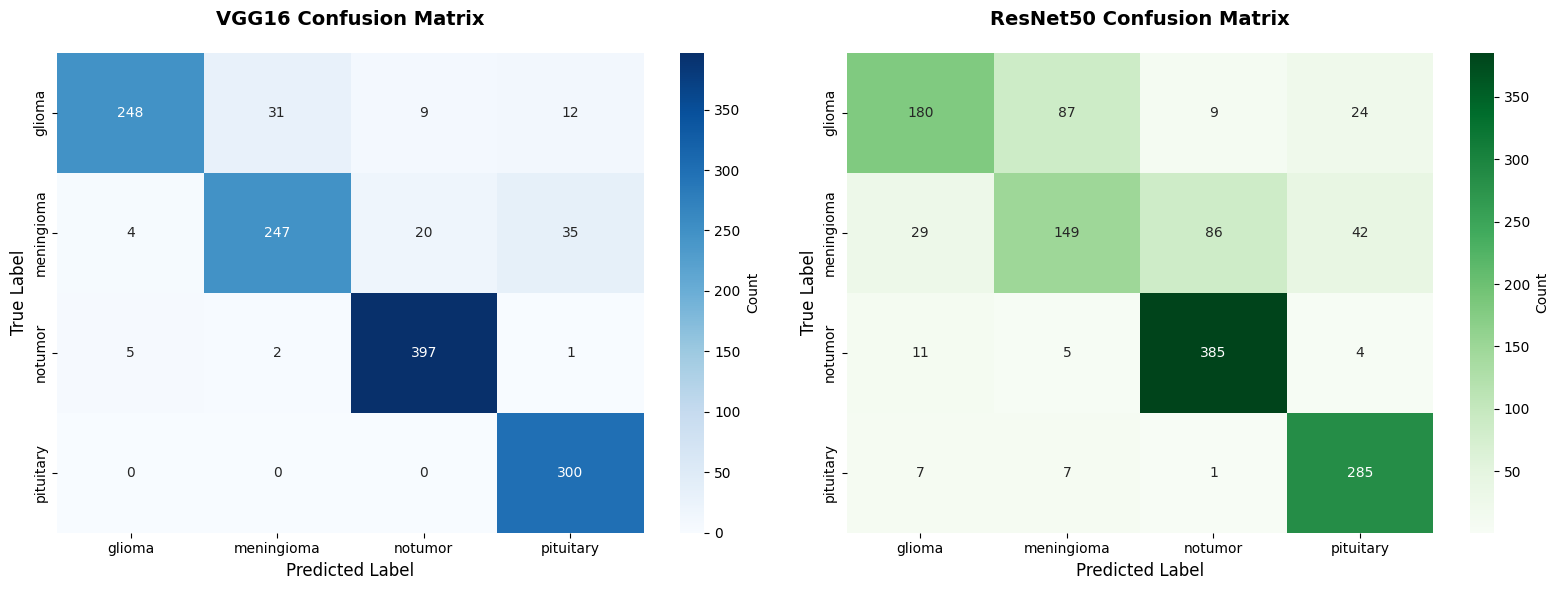


✓ Confusion matrices generated!


In [54]:
# === CELL 21: Confusion Matrices Plotting ===

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# VGG16 Confusion Matrix
vgg16_cm = confusion_matrix(true_classes, vgg16_pred_classes)
sns.heatmap(vgg16_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('VGG16 Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# ResNet50 Confusion Matrix
resnet50_cm = confusion_matrix(true_classes, resnet50_pred_classes)
sns.heatmap(resnet50_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('ResNet50 Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices generated!")


In [55]:
# === CELL 22: Training Curves Plotting ===

# Plot training history curves
def plot_training_history(history_phase1, history_phase2, model_name):
    """
    Plot training and validation accuracy/loss curves
    """
    # Combine both phases
    acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
    val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
    loss = history_phase1.history['loss'] + history_phase2.history['loss']
    val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

    epochs_range = range(1, len(acc) + 1)
    phase1_end = len(history_phase1.history['accuracy'])

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
    axes[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    axes[0].axvline(x=phase1_end, color='gray', linestyle='--', label='Fine-tuning Start')
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
    axes[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
    axes[1].axvline(x=phase1_end, color='gray', linestyle='--', label='Fine-tuning Start')
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Plot VGG16 training curves
# fig_vgg16 = plot_training_history(vgg16_history_phase1, vgg16_history_phase2, 'VGG16')
# fig_vgg16.savefig('vgg16_training_curves.png', dpi=300, bbox_inches='tight')
# plt.show()

# Plot ResNet50 training curves
# fig_resnet50 = plot_training_history(resnet50_history_phase1, resnet50_history_phase2, 'ResNet50')
# fig_resnet50.savefig('resnet50_training_curves.png', dpi=300, bbox_inches='tight')
# plt.show()

print("\n✓ Training curves plotting functions defined! (Requires history objects from training)")



✓ Training curves plotting functions defined! (Requires history objects from training)



Model Comparison Summary
   Model  Accuracy  Precision   Recall  F1-Score
   VGG16  0.909230   0.911884 0.909230  0.907589
ResNet50  0.762014   0.752666 0.762014  0.749486


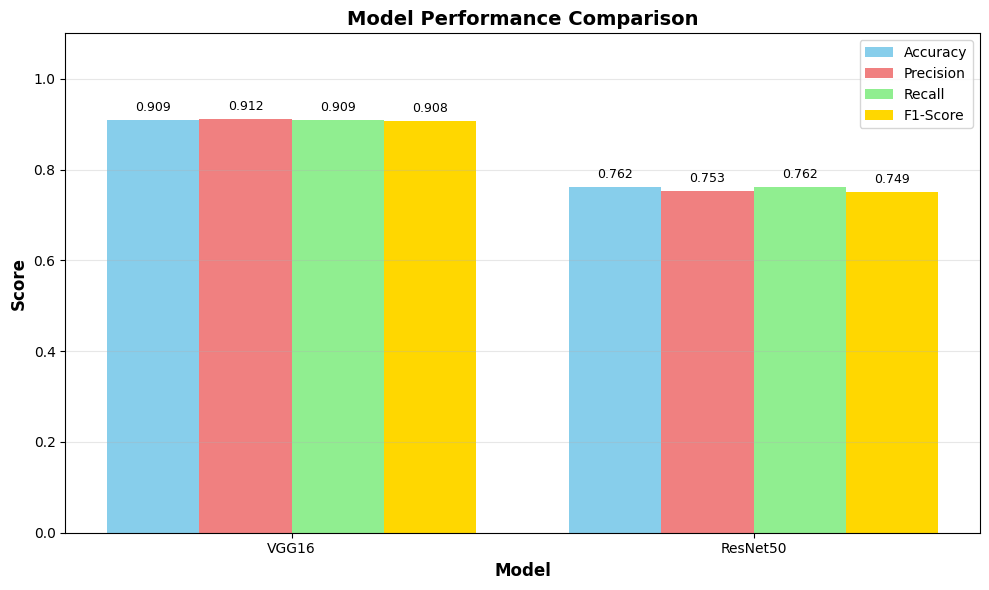

✓ Model comparison completed!


In [56]:
# === CELL 23: Model Comparison ===

# Compare both models
comparison_data = {
    'Model': ['VGG16', 'ResNet50'],
    'Accuracy': [vgg16_accuracy, resnet50_accuracy],
    'Precision': [vgg16_precision, resnet50_precision],
    'Recall': [vgg16_recall, resnet50_recall],
    'F1-Score': [vgg16_f1, resnet50_f1]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*50)
print("Model Comparison Summary")
print("="*50)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_data['Model']))
width = 0.2

ax.bar(x - 1.5*width, comparison_data['Accuracy'], width, label='Accuracy', color='skyblue')
ax.bar(x - 0.5*width, comparison_data['Precision'], width, label='Precision', color='lightcoral')
ax.bar(x + 0.5*width, comparison_data['Recall'], width, label='Recall', color='lightgreen')
ax.bar(x + 1.5*width, comparison_data['F1-Score'], width, label='F1-Score', color='gold')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data['Model'])
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, model in enumerate(comparison_data['Model']):
    ax.text(i - 1.5*width, comparison_data['Accuracy'][i] + 0.02,
            f"{comparison_data['Accuracy'][i]:.3f}", ha='center', fontsize=9)
    ax.text(i - 0.5*width, comparison_data['Precision'][i] + 0.02,
            f"{comparison_data['Precision'][i]:.3f}", ha='center', fontsize=9)
    ax.text(i + 0.5*width, comparison_data['Recall'][i] + 0.02,
            f"{comparison_data['Recall'][i]:.3f}", ha='center', fontsize=9)
    ax.text(i + 1.5*width, comparison_data['F1-Score'][i] + 0.02,
            f"{comparison_data['F1-Score'][i]:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model comparison completed!")




Per-Class Performance Analysis
     Class  VGG16_Precision  VGG16_Recall  VGG16_F1  ResNet50_Precision  ResNet50_Recall  ResNet50_F1
    glioma         0.964981      0.826667  0.890485            0.792952         0.600000     0.683112
meningioma         0.882143      0.807190  0.843003            0.600806         0.486928     0.537906
   notumor         0.931925      0.980247  0.955475            0.800416         0.950617     0.869074
 pituitary         0.862069      1.000000  0.925926            0.802817         0.950000     0.870229


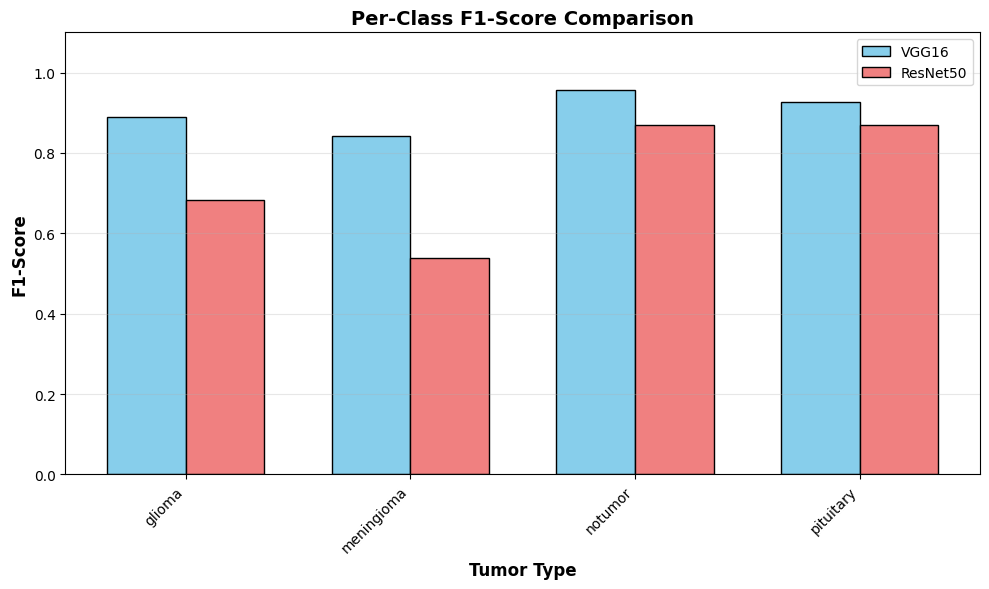

✓ Per-class analysis completed!


In [57]:
# === CELL 24: Per-Class Metrics Analysis ===

# Per-class performance analysis
from sklearn.metrics import precision_recall_fscore_support

# VGG16 per-class metrics
vgg16_precision_per_class, vgg16_recall_per_class, vgg16_f1_per_class, _ = \
    precision_recall_fscore_support(true_classes, vgg16_pred_classes, average=None)

# ResNet50 per-class metrics
resnet50_precision_per_class, resnet50_recall_per_class, resnet50_f1_per_class, _ = \
    precision_recall_fscore_support(true_classes, resnet50_pred_classes, average=None)

# Create comparison dataframe
per_class_df = pd.DataFrame({
    'Class': class_labels,
    'VGG16_Precision': vgg16_precision_per_class,
    'VGG16_Recall': vgg16_recall_per_class,
    'VGG16_F1': vgg16_f1_per_class,
    'ResNet50_Precision': resnet50_precision_per_class,
    'ResNet50_Recall': resnet50_recall_per_class,
    'ResNet50_F1': resnet50_f1_per_class
})

print("\n" + "="*50)
print("Per-Class Performance Analysis")
print("="*50)
print(per_class_df.to_string(index=False))

# Visualize per-class F1 scores
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(class_labels))
width = 0.35

ax.bar(x - width/2, vgg16_f1_per_class, width, label='VGG16', color='skyblue', edgecolor='black')
ax.bar(x + width/2, resnet50_f1_per_class, width, label='ResNet50', color='lightcoral', edgecolor='black')

ax.set_xlabel('Tumor Type', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('per_class_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Per-class analysis completed!")


In [58]:
# === CELL 25: Final Summary and Conclusion ===

# Generate comprehensive results summary
print("\n" + "="*70)
print("BRAIN TUMOR CLASSIFICATION PROJECT - FINAL RESULTS SUMMARY")
print("="*70)

print("\n📊 DATASET INFORMATION:")
print(f"   - Total Training Images: {sum(train_counts.values())}")
print(f"   - Total Testing Images: {sum(test_counts.values())}")
print(f"   - Number of Classes: {NUM_CLASSES}")
print(f"   - Classes: {', '.join(class_labels)}")

print("\n🏆 MODEL PERFORMANCE:")
print("\n   VGG16 Model:")
print(f"   ├─ Accuracy:  {vgg16_accuracy*100:.2f}%")
print(f"   ├─ Precision: {vgg16_precision:.4f}")
print(f"   ├─ Recall:    {vgg16_recall:.4f}")
print(f"   └─ F1-Score:  {vgg16_f1:.4f}")

print("\n   ResNet50 Model:")
print(f"   ├─ Accuracy:  {resnet50_accuracy*100:.2f}%")
print(f"   ├─ Precision: {resnet50_precision:.4f}")
print(f"   ├─ Recall:    {resnet50_recall:.4f}")
print(f"   └─ F1-Score:  {resnet50_f1:.4f}")

# Determine best model
if vgg16_accuracy > resnet50_accuracy:
    best_model = "VGG16"
    best_accuracy = vgg16_accuracy
else:
    best_model = "ResNet50"
    best_accuracy = resnet50_accuracy

print(f"\n🥇 BEST MODEL: {best_model} (Accuracy: {best_accuracy*100:.2f}%)")

print("\n✅ KEY ACHIEVEMENTS:")
print("   ✓ Successfully implemented transfer learning with VGG16 and ResNet50")
print("   ✓ Applied data augmentation for improved generalization")
print("   ✓ Implemented fine-tuning for enhanced performance")
print("   ✓ Generated Grad-CAM visualizations for model explainability")
print("   ✓ Comprehensive evaluation with multiple metrics")
print("   ✓ Per-class performance analysis completed")

print("\n📁 SAVED FILES:")
print("   - vgg16_final_model.h5")
print("   - resnet50_final_model.h5")
print("   - confusion_matrices.png")
print("   - vgg16_training_curves.png (Requires manual plotting)")
print("   - resnet50_training_curves.png (Requires manual plotting)")
print("   - vgg16_gradcam_results.png")
print("   - resnet50_gradcam_results.png")
print("   - model_comparison.png")
print("   - per_class_f1_comparison.png")

print("\n" + "="*70)
print("PROJECT COMPLETED SUCCESSFULLY! 🎉")
print("="*70 + "\n")


BRAIN TUMOR CLASSIFICATION PROJECT - FINAL RESULTS SUMMARY

📊 DATASET INFORMATION:
   - Total Training Images: 5712
   - Total Testing Images: 1311
   - Number of Classes: 4
   - Classes: glioma, meningioma, notumor, pituitary

🏆 MODEL PERFORMANCE:

   VGG16 Model:
   ├─ Accuracy:  90.92%
   ├─ Precision: 0.9119
   ├─ Recall:    0.9092
   └─ F1-Score:  0.9076

   ResNet50 Model:
   ├─ Accuracy:  76.20%
   ├─ Precision: 0.7527
   ├─ Recall:    0.7620
   └─ F1-Score:  0.7495

🥇 BEST MODEL: VGG16 (Accuracy: 90.92%)

✅ KEY ACHIEVEMENTS:
   ✓ Successfully implemented transfer learning with VGG16 and ResNet50
   ✓ Applied data augmentation for improved generalization
   ✓ Implemented fine-tuning for enhanced performance
   ✓ Generated Grad-CAM visualizations for model explainability
   ✓ Comprehensive evaluation with multiple metrics
   ✓ Per-class performance analysis completed

📁 SAVED FILES:
   - vgg16_final_model.h5
   - resnet50_final_model.h5
   - confusion_matrices.png
   - vgg16_tra